In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor,  Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


### Model Evaluation Comparison

| Model               | MSE           | R² Score        | MAE         |
|---------------------|---------------|------------------|-------------|
| CatBoost |**1489.73**             | **0.8882**       | **17.14**    |
| Linear Regression   | 4009.33       | 0.6146           | 42.15       |
| Random Forest       | 2379.51       | 0.7713           | 27.09       |
| MLP Regressor       | 2529.22       | 0.7569           | 26.48       |
| SVM                 | 4742.08       | 0.5442           | 40.78       |
| XGBoost             | 1683.80       | 0.8382           | 22.68       |
| LightGBM            | 1723.32       | 0.8344           | 23.02       |
| ElasticNet          | 4540.56       | 0.5636           | 44.21       |
| GradientBoosting    | 2763.76       | 0.7343           | 33.70       |


In [10]:
feature_df = pd.read_csv('/kaggle/input/finalfeatures/final_features.csv')
feature_df.head()


,id,price,accommodates,bedrooms,beds,calculated_host_listings_count,has_availability,host_acceptance_rate,host_has_profile_pic,host_identity_verified,...,amenity_central_heating,amenity_conditioner,amenity_private_entrance,amenity_clothing_storage,amenity_luggage_dropoff_allowed,amenity_coffee_maker,amenity_exterior_security_cameras_on_property,amenity_portable_fans,amenity_dryer,amenity_free_parking_on_premises
0,91031,94.0,2,1.0,1.0,1,1,0.56,1,1,...,0,0,0,0,0,0,0,0,0,0
1,92399,86.0,2,1.0,1.0,2,1,0.80,1,1,...,0,1,1,0,0,0,0,0,0,0
2,93015,175.0,5,2.0,3.0,1,1,1.00,1,1,...,0,0,1,0,0,1,0,1,0,0
3,93457,153.0,4,1.0,2.0,1,1,1.00,1,1,...,0,1,0,1,1,1,0,0,0,0
4,93783,350.0,4,2.0,3.0,1,1,0.80,1,1,...,0,1,1,0,1,0,0,0,1,0


In [11]:
n = 600
print(f"Filtering data for prices < ${n:,}")
feature_df = feature_df[feature_df['price'] < n].copy()
print(f"Number of listings in the filtered dataset: {len(feature_df)}")
print("\n" + "="*50 + "\n")


Filtering data for prices < $600
Number of listings in the filtered dataset: 58402




In [12]:
columns_to_ignore = []
target_column = 'price'
id_column = 'id'
model_infos = {}


In [13]:
print("Final Data Preparation: Type Conversion, Splitting, and Scaling")

y = feature_df[target_column]
X = feature_df.drop(columns=[target_column, id_column])
X = X.astype('float64')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

columns_to_scale = [col for col in X.columns if col not in columns_to_ignore]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


Final Data Preparation: Type Conversion, Splitting, and Scaling


In [14]:


def evaluate_model(name, model, X_test, y_test, y_pred, extra_info=None):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    model_infos[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_true': y_test,
        'mse': mse,
        'r2': r2,
        'mae': mae
    }
    if extra_info:
        model_infos[name].update(extra_info)
    print(f"{name} - MSE: {mse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f}")


In [15]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
evaluate_model('Linear Regression', lr, X_test_scaled, y_test, lr.predict(X_test_scaled))

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)
evaluate_model('Polynomial Regression', poly_lr, X_test_poly, y_test, poly_lr.predict(X_test_poly))

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
evaluate_model('Random Forest', rf, X_test_scaled, y_test, rf.predict(X_test_scaled))

mlp = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=300, random_state=42, verbose=False)
mlp.fit(X_train_scaled, y_train)
evaluate_model('MLP Regressor', mlp, X_test_scaled, y_test, mlp.predict(X_test_scaled),
               extra_info={'loss_curve': mlp.loss_curve_, 'epochs': len(mlp.loss_curve_)})

svm = SVR()
svm.fit(X_train_scaled, y_train)
evaluate_model('SVM', svm, X_test_scaled, y_test, svm.predict(X_test_scaled))

catboost = CatBoostRegressor(verbose=0, random_state=42)
catboost.fit(X_train_scaled, y_train)
evaluate_model('CatBoost', catboost, X_test_scaled, y_test, catboost.predict(X_test_scaled))

xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb.fit(X_train_scaled, y_train)
evaluate_model('XGBoost', xgb, X_test_scaled, y_test, xgb.predict(X_test_scaled))

lgbm = LGBMRegressor(n_estimators=100, random_state=42)
lgbm.fit(X_train_scaled, y_train)
evaluate_model('LightGBM', lgbm, X_test_scaled, y_test, lgbm.predict(X_test_scaled))

elastic = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic.fit(X_train_scaled, y_train)
evaluate_model('ElasticNet', elastic, X_test_scaled, y_test, elastic.predict(X_test_scaled))

gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train_scaled, y_train)
evaluate_model('GradientBoosting', gbr, X_test_scaled, y_test, gbr.predict(X_test_scaled))


Linear Regression - MSE: 4009.33, R²: 0.6146, MAE: 42.15
Polynomial Regression - MSE: 2063778370550634.75, R²: -198373359704.8684, MAE: 1013274.84
Random Forest - MSE: 2379.51, R²: 0.7713, MAE: 27.09


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Regressor - MSE: 2529.22, R²: 0.7569, MAE: 26.48
SVM - MSE: 4742.08, R²: 0.5442, MAE: 40.78
CatBoost - MSE: 1489.73, R²: 0.8568, MAE: 18.63
XGBoost - MSE: 1683.80, R²: 0.8382, MAE: 22.68
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3859
[LightGBM] [Info] Number of data points in the train set: 46721, number of used features: 125
[LightGBM] [Info] Start training from score 145.413026
LightGBM - MSE: 1723.32, R²: 0.8344, MAE: 23.02
ElasticNet - MSE: 4540.56, R²: 0.5636, MAE: 44.21
GradientBoosting - MSE: 2763.76, R²: 0.7343, MAE: 33.70


In [17]:
def plot_predictions(model_name):
    info = model_infos[model_name]
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=info['y_true'], y=info['y_pred'], alpha=0.6)
    plt.xlabel("True Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{model_name} - True vs Predicted")
    plt.plot([info['y_true'].min(), info['y_true'].max()],
             [info['y_true'].min(), info['y_true'].max()], 'r--')
    plt.grid(True)
    plt.show()

def plot_mlp_loss():
    mlp_info = model_infos.get('MLP Regressor')
    if mlp_info and 'loss_curve' in mlp_info:
        plt.figure(figsize=(8, 4))
        plt.plot(mlp_info['loss_curve'])
        plt.title('MLP Training Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

def plot_model_scores():
    r2_scores = {name: info['r2'] for name, info in model_infos.items()}
    mse_scores = {name: info['mse'] for name, info in model_infos.items()}
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].barh(list(r2_scores.keys()), list(r2_scores.values()), color='skyblue')
    axs[0].set_title("R² Score per Model")
    axs[0].set_xlabel("R²")
    axs[0].grid(True)

    axs[1].barh(list(mse_scores.keys()), list(mse_scores.values()), color='salmon')
    axs[1].set_title("Mean Squared Error per Model")
    axs[1].set_xlabel("MSE")
    axs[1].invert_xaxis()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


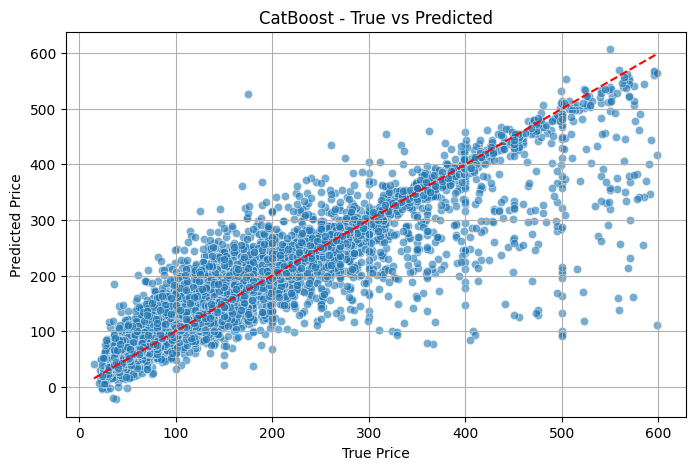

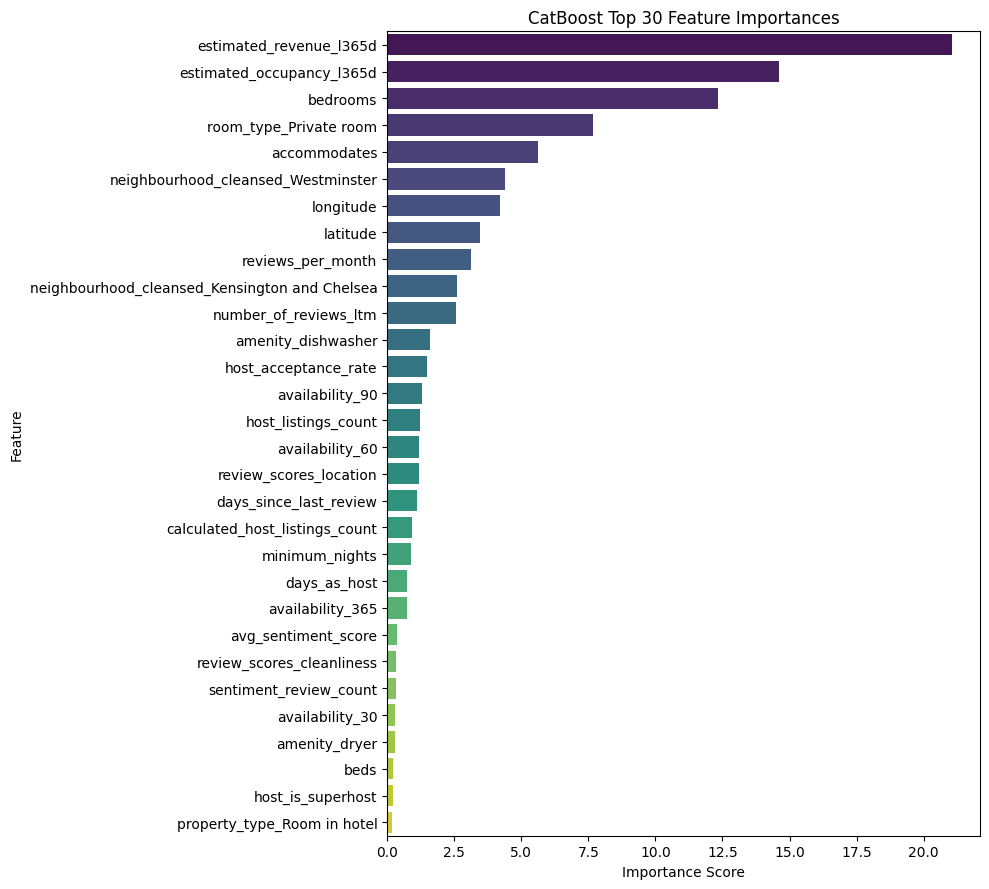

CatBoost MAE on entire dataset: 17.14
CatBoost R² score on entire dataset: 0.8882


In [23]:

plot_predictions('CatBoost')

def plot_catboost_feature_importance(model, feature_names, top_n=30):
    importances = model.get_feature_importance()
    sorted_idx = np.argsort(importances)[::-1][:top_n]
    top_features = np.array(feature_names)[sorted_idx]
    top_importances = importances[sorted_idx]

    plt.figure(figsize=(10, max(6, 0.3 * top_n)))
    sns.barplot(x=top_importances, y=top_features, palette="viridis")
    plt.title(f"CatBoost Top {top_n} Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

plot_catboost_feature_importance(catboost, X.columns, top_n=30)

X_scaled_full = X.copy()
X_scaled_full[columns_to_scale] = scaler.transform(X[columns_to_scale])

catboost_preds_full = catboost.predict(X_scaled_full)

r2_full = r2_score(y, catboost_preds_full)
mae_full = mean_absolute_error(y, catboost_preds_full)

print(f"CatBoost MAE on entire dataset: {mae_full:.2f}")
print(f"CatBoost R² score on entire dataset: {r2_full:.4f}")




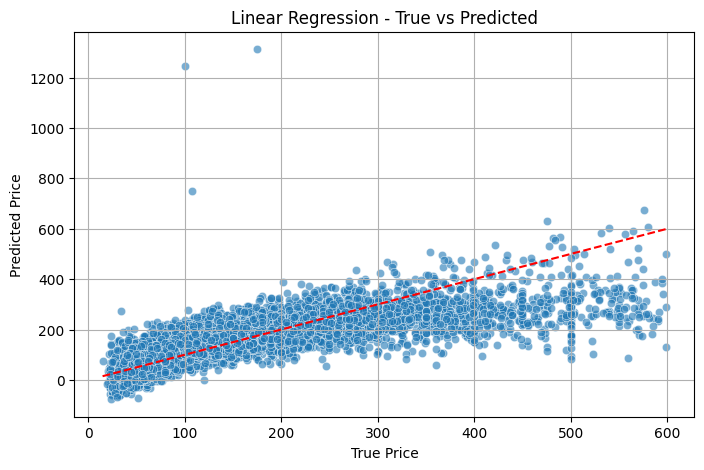

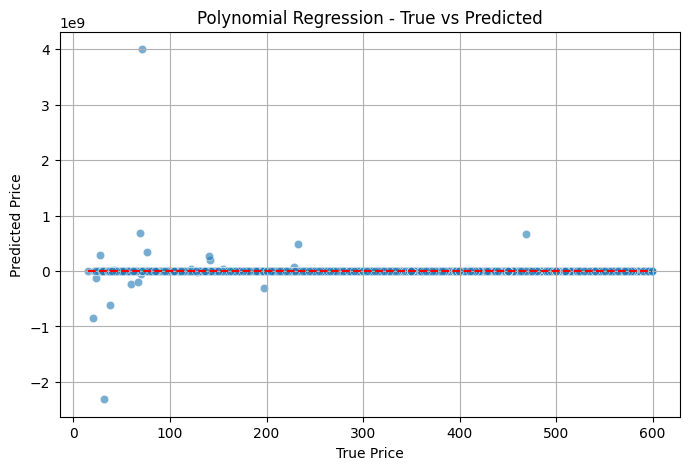

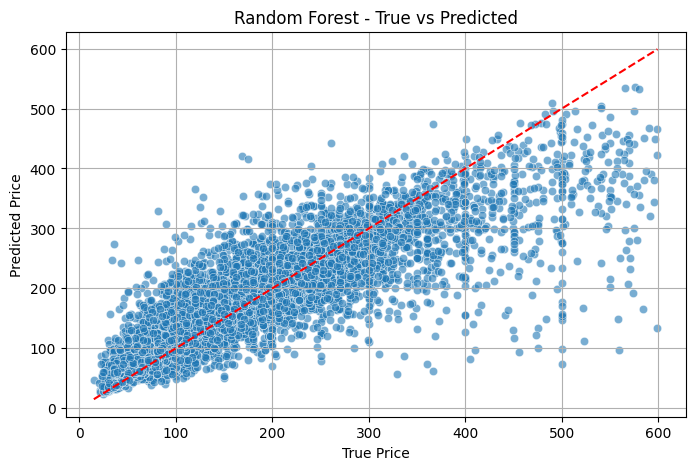

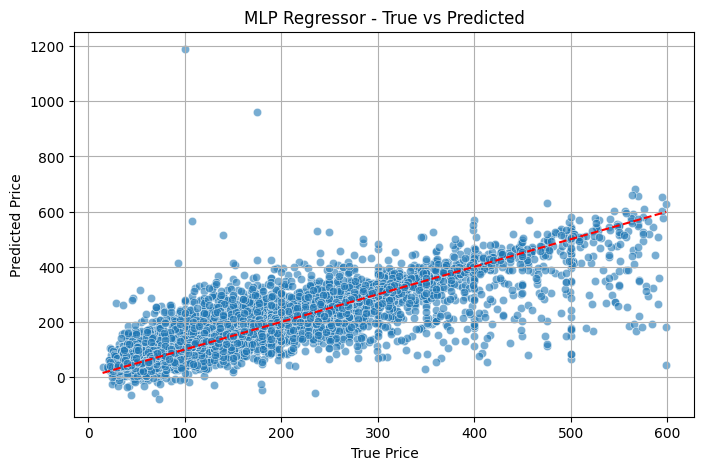

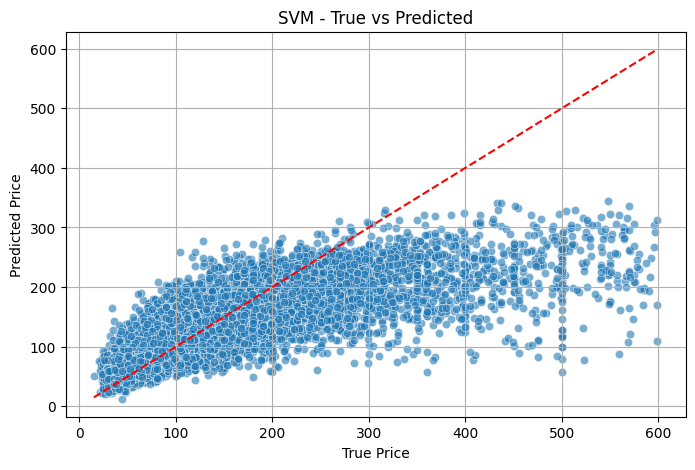

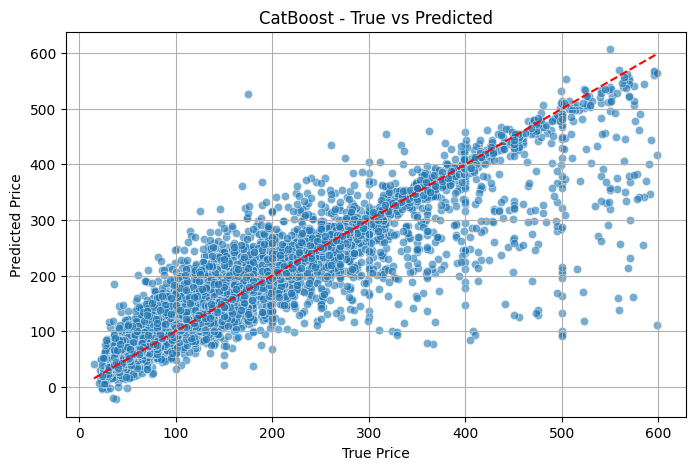

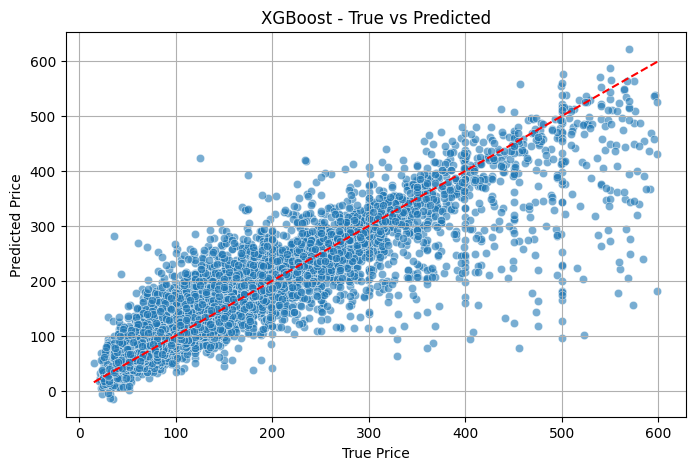

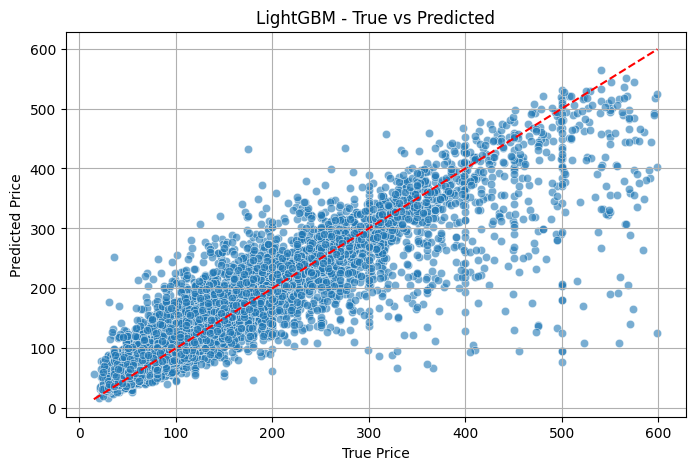

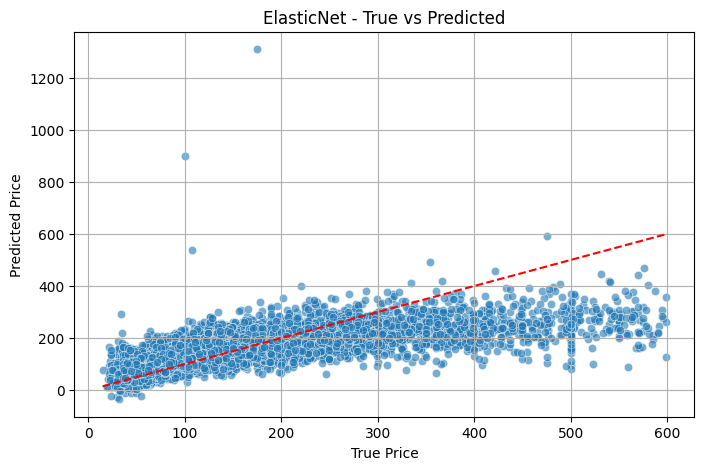

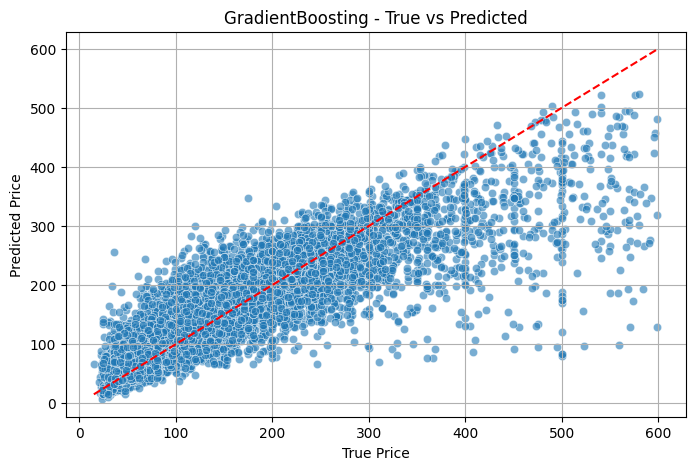

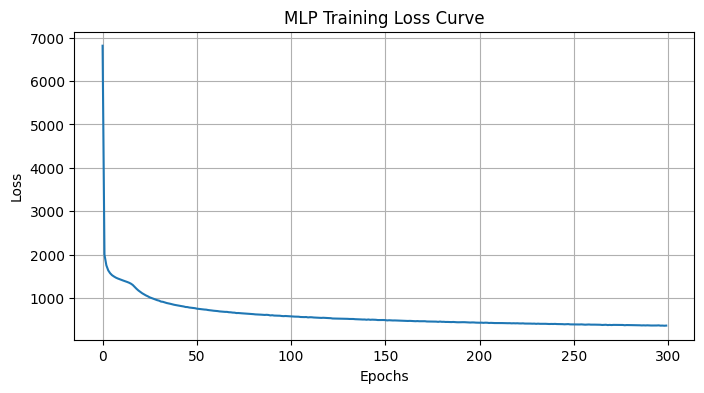

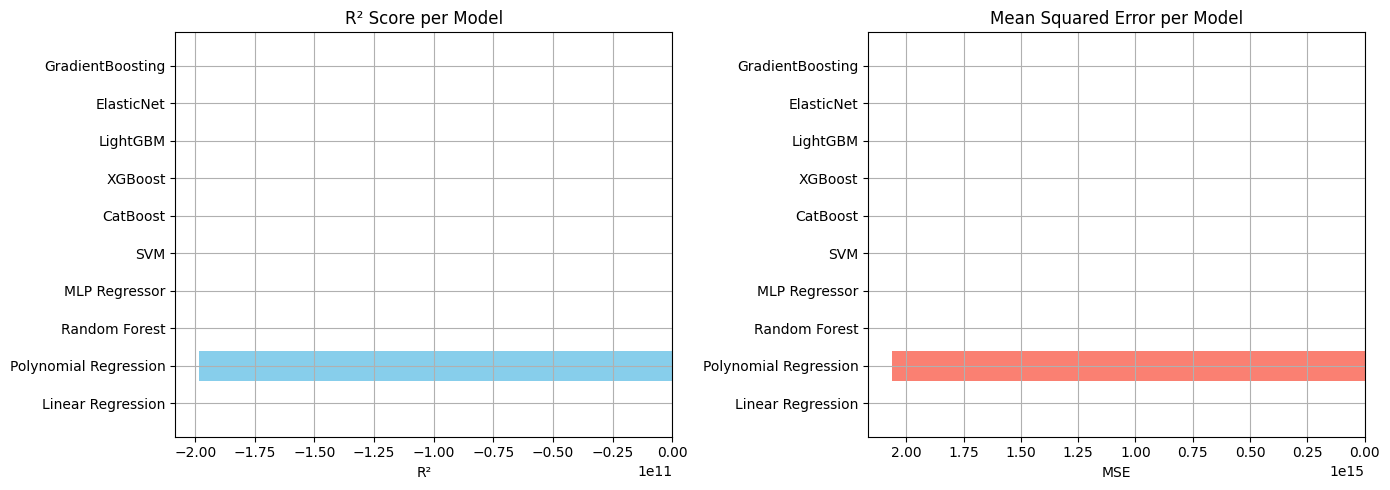

In [19]:
for name in model_infos.keys():
    plot_predictions(name)

plot_mlp_loss()

plot_model_scores()


In [20]:
import json

for name, info in model_infos.items():
    df_export = pd.DataFrame({
        'y_true': info['y_true'],
        'y_pred': info['y_pred']
    })
    df_export.to_csv(f"{name.replace(' ', '_').lower()}_predictions.csv", index=False)

metrics_df = pd.DataFrame({
    'Model': list(model_infos.keys()),
    'MSE': [info['mse'] for info in model_infos.values()],
    'R2': [info['r2'] for info in model_infos.values()]
})
metrics_df.to_csv("model_metrics_summary.csv", index=False)

print("Exported prediction and metrics CSV files.")


Exported prediction and metrics CSV files.


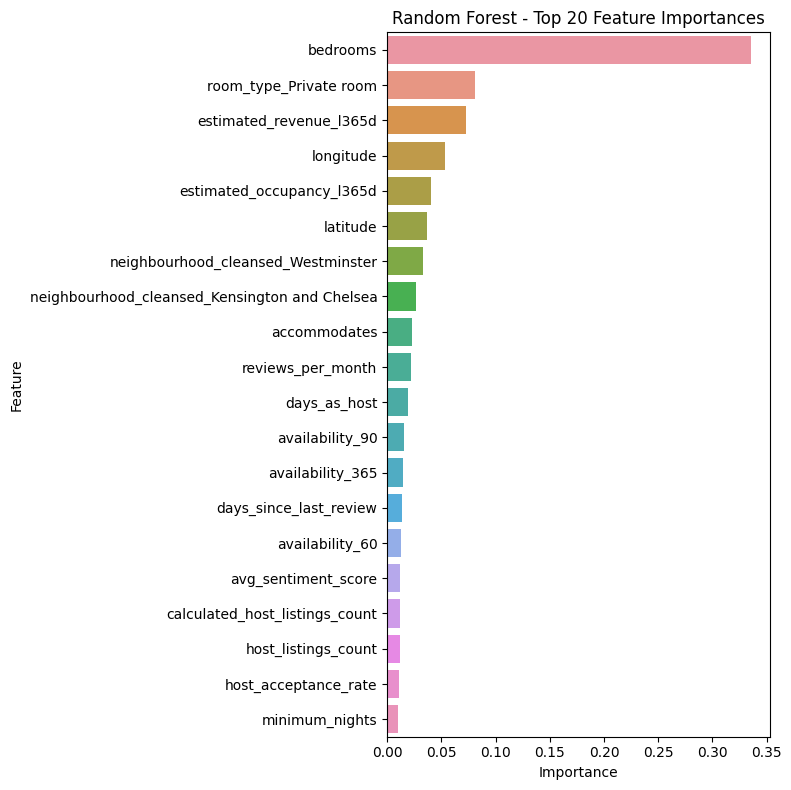

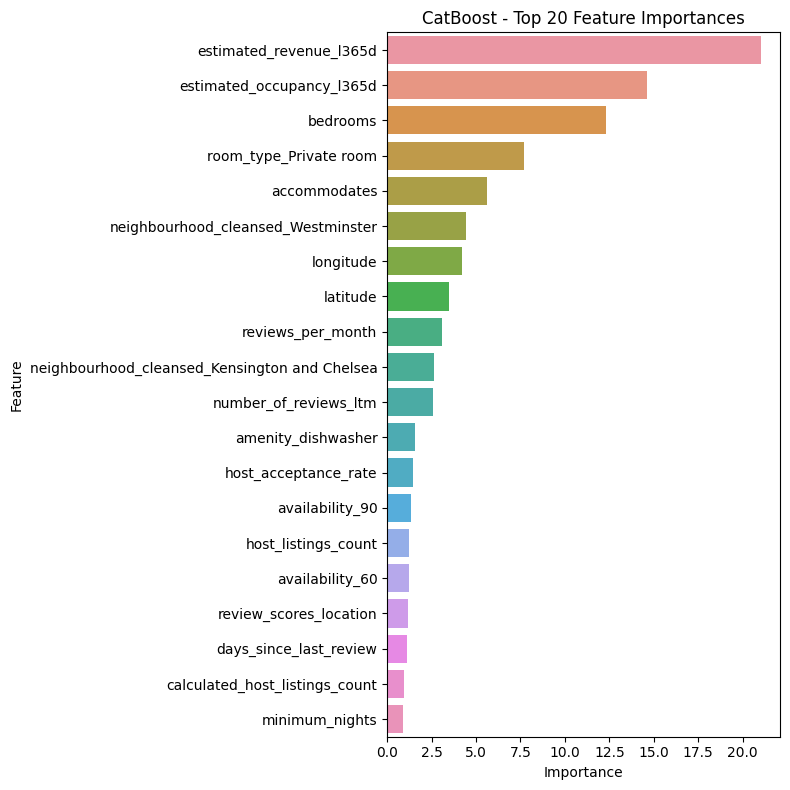

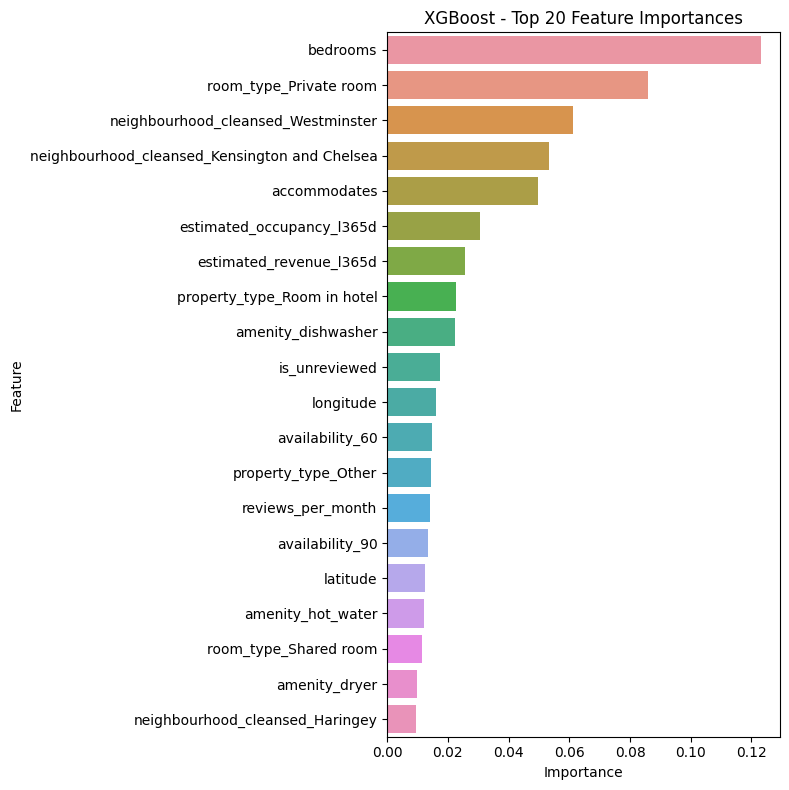

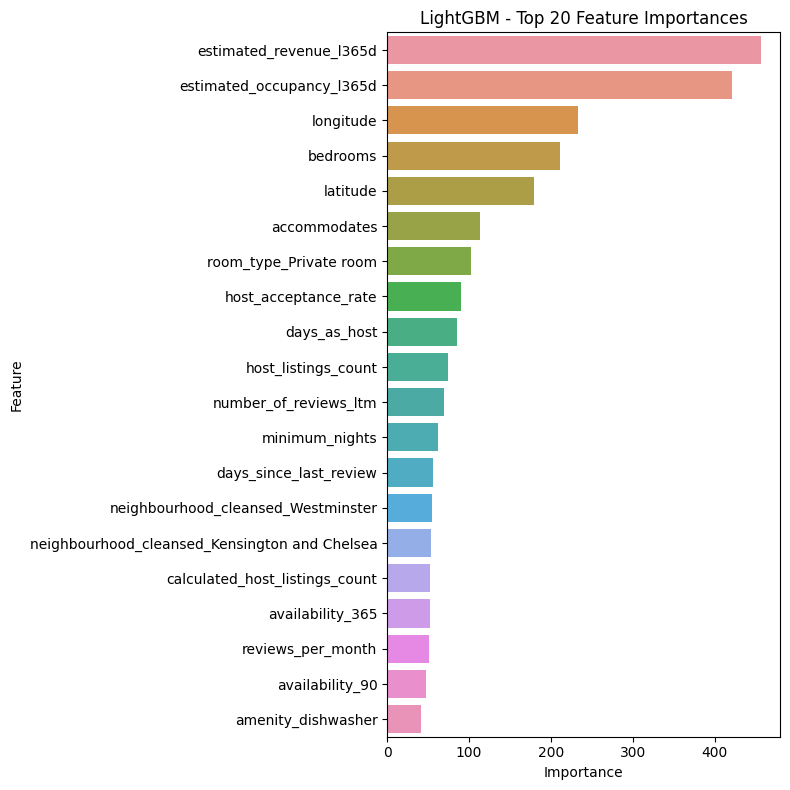

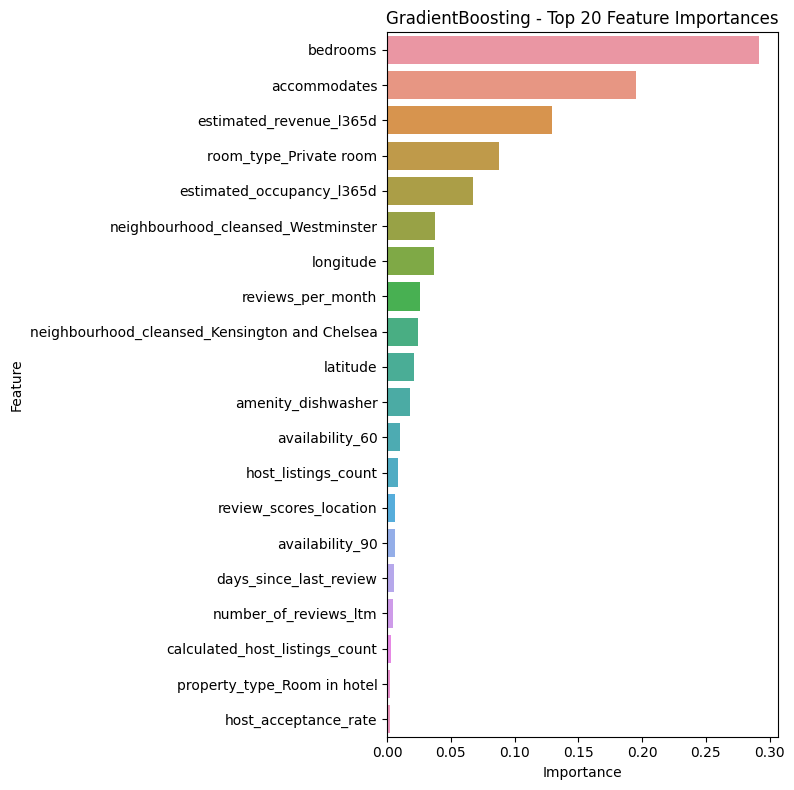

In [21]:

def plot_feature_importance(model_name, top_n=20):
    info = model_infos[model_name]
    model = info['model']

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features = X.columns
        fi_df = pd.DataFrame({'Feature': features, 'Importance': importances})
        fi_df = fi_df.sort_values(by='Importance', ascending=False).head(top_n)

        plt.figure(figsize=(8, top_n * 0.3 + 2))  # dynamic height
        sns.barplot(x='Importance', y='Feature', data=fi_df)
        plt.title(f'{model_name} - Top {top_n} Feature Importances')
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importance.")


for m in ['Random Forest', 'CatBoost', 'XGBoost', 'LightGBM', 'GradientBoosting']:
    plot_feature_importance(m)


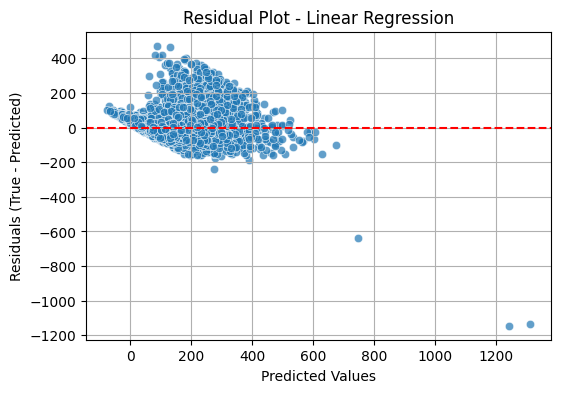

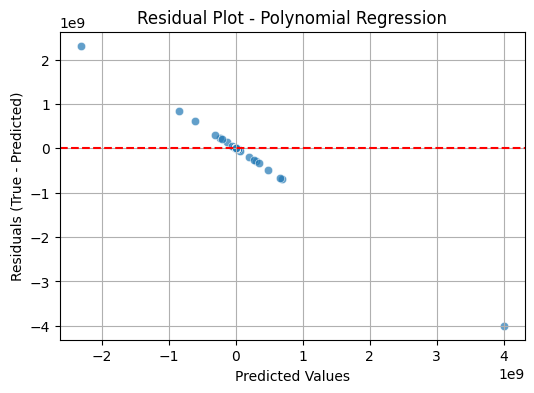

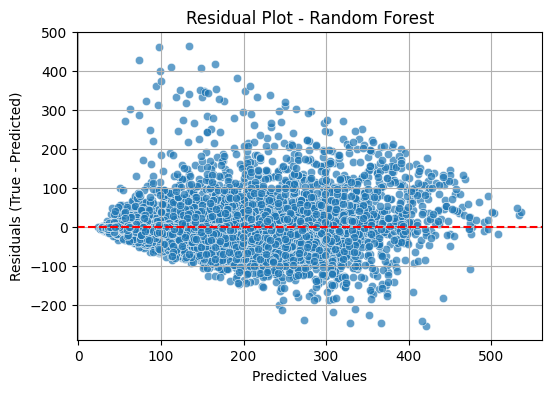

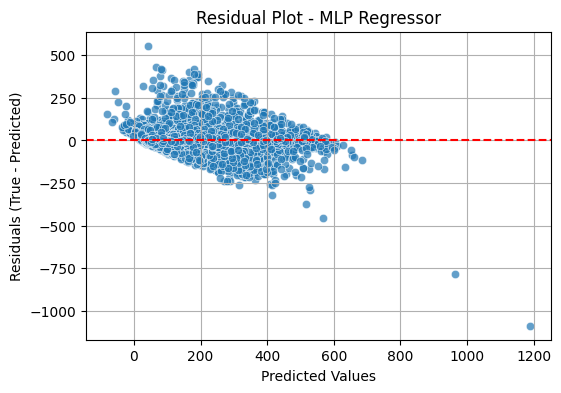

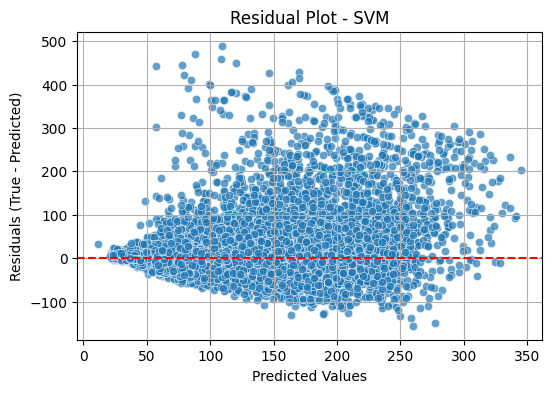

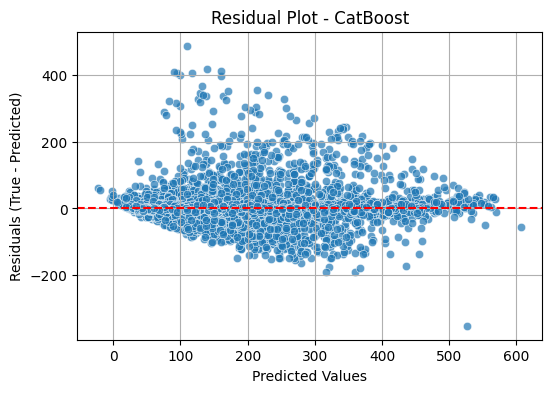

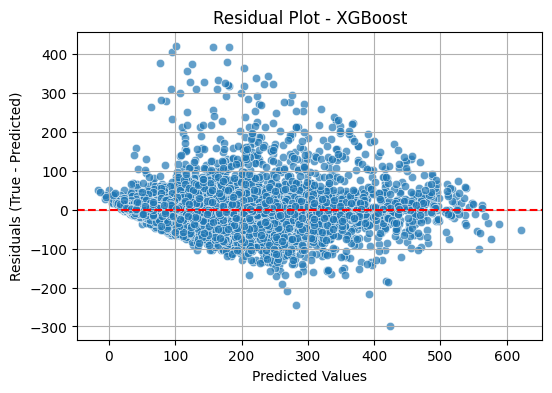

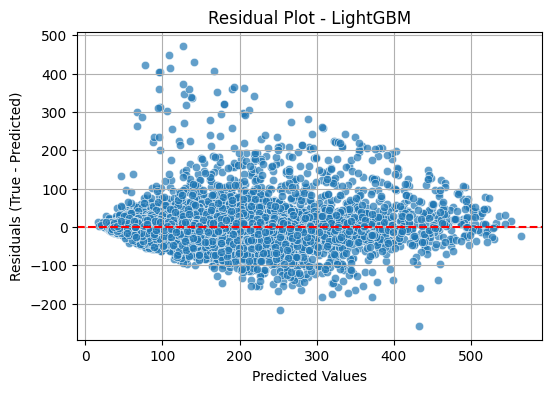

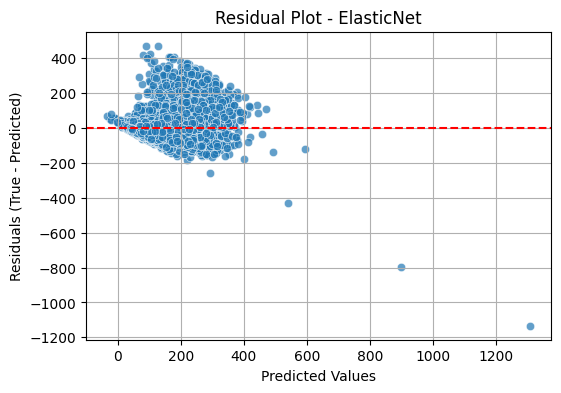

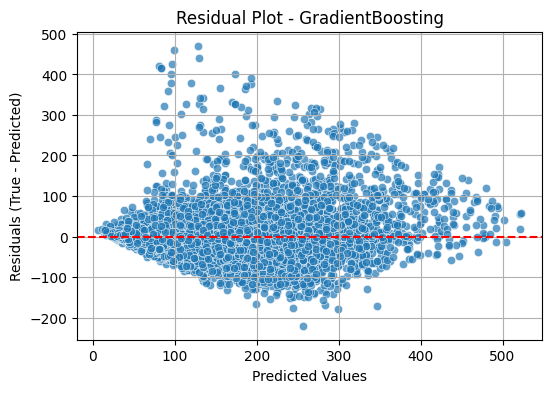

In [22]:
def plot_residuals(model_name):
    info = model_infos[model_name]
    residuals = info['y_true'] - info['y_pred']

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=info['y_pred'], y=residuals, alpha=0.7)
    plt.axhline(0, linestyle='--', color='r')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (True - Predicted)")
    plt.title(f"Residual Plot - {model_name}")
    plt.grid(True)
    plt.show()

for name in model_infos:
    plot_residuals(name)
